In [1]:
########################################
#LIBRARIES

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import sklearn
import os

########################################
#PARAMETERS
nTimeSteps = 60; #at 60 Hz
epochs = 200
minibatch_size= 50
input_size = 15
samplenum_target = 15000
samplenum_target_test = 5000
hiddenlayers = [100, 200]
use_case = 'varstart'
learning_rate = 0.01
LRdecay = 0.7
model_file_path = '../Trained_Models/'
sample_file_path = f'/Users/nicovonau/Code/thesis_pytorch/Data/Samples/data_{use_case}_{nTimeSteps}tsteps_1507/'
simulation_file_path = '/Users/nicovonau/Code/thesis_pytorch/Data/Simulations/pm_target.sim'
objective_file_path = f'/Users/nicovonau/Code/thesis_pytorch/Data/Objectives/pm_stiff.obj'
# set log level
dde.set_log_level(dde.LogLevel.off)
print(os.listdir(sample_file_path))

dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
output_size = dyn.nParameters*nTimeSteps

['data_1.json', '.DS_Store', 'data_0.json', 'data_10.json', 'Sampling_varstart.py', 'data_7.json', 'data_test', 'data_6.json', 'data_11.json', 'Description.json', 'data_9.json', 'data_12.json', 'data_5.json', 'data_4.json', 'data_8.json', 'data_13.json', 'data_3.json', 'vari60.out', 'data_14.json', 'data_15.json', 'data_2.json']


In [2]:
#########################################
#LOAD TRAINING SAMPLES
number_of_files = len(os.listdir(sample_file_path))-5
samplenum = 1000*number_of_files
output_size = dyn.nParameters*nTimeSteps

p = np.zeros((samplenum, dyn.nParameters*nTimeSteps))
input = np.zeros((samplenum, input_size))

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q_target'])
        for i, p_i in enumerate(data['p']):
            p[filenum*filesize+i, :] = np.array(p_i)
        for i, q_target_i in enumerate(data['q_target']):
            input[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data['q']):
            input[filenum*filesize+i, 3:6] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input[filenum*filesize+i, 6:9] = np.array(qdot_i)
        for i, qddot_i in enumerate(data['qddot']):
            input[filenum*filesize+i, 9:12] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input[filenum*filesize+i, 12:15] = np.array(p_now_i)

print(f'Shape of input: {input.shape}')
print(f'Shape of p: {p.shape}')
#Remove zeros
p = p[~(input == 0).all(1)]
input = input[~(input == 0).all(1)]

print(f'Shape of input after removing faulty samples: {input.shape}')
print(f'Shape of p after removing faulty samples: {p.shape}')

data = input[0:samplenum_target, :]
p = p[0:samplenum_target, :]
print(data.shape)
print(p.shape)

# Splitting the dataset into the Training set and Test set
#from sklearn.model_selection import train_test_split
#y_train, y_test, p_train, p_test = train_test_split(y_target, p, test_size = testsize)

#y_target = torch.tensor(y_train).float()
#p = torch.tensor(p_train).float()
data = torch.tensor(data).float()
p = torch.tensor(p).float()
#y_test = torch.tensor(y_test).float()
#p_test = torch.tensor(p_test).float()

#########################################
#LOAD TEST SAMPLES
number_of_files_test = len(os.listdir(sample_file_path + 'data_test/'))
samplenum_test = 1000*number_of_files_test

p_test = np.zeros((samplenum_test, dyn.nParameters*nTimeSteps))
input_test = np.zeros((samplenum_test, input_size))

for filenum in range(number_of_files_test):
    with open(sample_file_path + f'data_test/data_{filenum}.json') as json_file:
        data_ = json.load(json_file)
        filesize = len(data_['q_target'])
        for i, p_i in enumerate(data_['p']):
            p_test[filenum*filesize+i,:] = np.array(p_i)
        for i, q_target_i in enumerate(data_['q_target']):
            input_test[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data_['q']):
            input_test[filenum*filesize+i, 3:6] = np.array(q_i)
        for i, qdot_i in enumerate(data_['qdot']):
            input_test[filenum*filesize+i, 6:9] = np.array(qdot_i)
        for i, qddot_i in enumerate(data_['qddot']):
            input_test[filenum*filesize+i, 9:12] = np.array(qddot_i)
        for i, p_now_i in enumerate(data_['p_now']):
            input_test[filenum*filesize+i, 12:15] = np.array(p_now_i)

print(f'\nShape of input_test: {input_test.shape}')
print(f'Shape of p_test: {p_test.shape}')
#Remove zeros
p_test = p_test[~(input_test == 0).all(1)]
input_test = input_test[~(input_test == 0).all(1)]

print(f'Shape of input_test after removing faulty samples: {input_test.shape}')
print(f'Shape of p_test after removing faulty samples: {p_test.shape}')

input_test = input_test[0:samplenum_target_test, :]
p_test = p_test[0:samplenum_target_test, :]
print(input_test.shape)
print(p_test.shape)

input_test = torch.tensor(input_test).float()
p_test = torch.tensor(p_test).float()

Shape of input: (16000, 15)
Shape of p: (16000, 180)
Shape of input after removing faulty samples: (15937, 15)
Shape of p after removing faulty samples: (15937, 180)
(15000, 15)
(15000, 180)

Shape of input_test: (6000, 15)
Shape of p_test: (6000, 180)
Shape of input_test after removing faulty samples: (5975, 15)
Shape of p_test after removing faulty samples: (5975, 180)
(5000, 15)
(5000, 180)


epoch:   0/10    LR:   0.001000  loss: 0.10653702
Model 0 trained
epoch:   9 final loss: 0.25660628
Training completed. Total duration: 189.499 min
TOTAL ERROR: 1432.7838941663504    mean error: 0.28655678033828735  epochs: 10    batchsize: 100   LRdecay: 0.7  hiddenlayer[80, 150]

NEXT MODEL
epoch:   0/5    LR:   0.001000  loss: 0.10074722
Model 1 trained
epoch:   4 final loss: 0.20175515
Training completed. Total duration: 202.547 min
TOTAL ERROR: 953.3589119315147    mean error: 0.19067178666591644  epochs: 5    batchsize: 100   LRdecay: 0.7  hiddenlayer[80, 150]

NEXT MODEL

Duration: 202.570 min


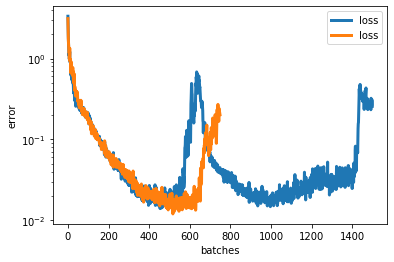

In [6]:
#########################################
#Parameters
learning_rate = 0.001
epochs_s = [10, 5]
minibatch_size = [100]
LRdecay_s = [0.7]
hiddenlayers_s = [[80, 150]] 
layerz = len(hiddenlayers_s)

##########################################
#BUILD CUSTOM SIMULATION FUNCTION
class Simulate(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input, data_input):
        p_ = input.detach().clone().numpy()
        bs = len(p_[:,0])
        q_pred = torch.ones([bs,dyn.nDofs*nTimeSteps])
        for i in range(bs):
            dyn.q0 = data_input[i, 3:6]
            dyn.qdot0 = data_input[i, 6:9]
            dyn.qddot0 = data_input[i, 9:12]
            dyn.p0 = data_input[i, 12:15]
            state = dyn.q(p_[i,:])
            q_pred[i, :] = torch.tensor(state.q)
        data_input_ = torch.tensor(data_input)
        ctx.save_for_backward(input, data_input)
        
        return q_pred
        
    @staticmethod
    def backward(ctx, grad_output):
        #print(grad_output)
        input, data_input = ctx.saved_tensors
        p_ = input.detach().clone().numpy()
        bs = len(p_[:,0])
        data_input = data_input.detach().clone().numpy()
        dq_dp_batch = torch.zeros([dyn.nDofs*nTimeSteps, dyn.nParameters*nTimeSteps])
        for i in range(bs):
            dyn.q0 = data_input[i, 3:6]
            dyn.qdot0 = data_input[i, 6:9]
            dyn.qddot0 = data_input[i, 9:12]
            dyn.p0 = data_input[i, 12:15]
            state = dyn.q(p_[i, :])
            dq_dp = dyn.dq_dp(state, p[i, :])
            dq_dp = torch.tensor(dq_dp)
            dq_dp_batch = dq_dp_batch + dq_dp
        #print(f'dq/dp_batch: {dy_dp_batch/samplenum}')
        
        grad_input = grad_output.mm(dq_dp_batch.float()/bs)
        #print(f'shape of grad input: {grad_input.shape}')
        #print(f'shape of grad output: {grad_output.shape}')
        return grad_input, None

Simulate = Simulate.apply

##########################################
# START GRIDSEARCH
start_time = time.time()
weight_c1 = 10 # q error
weight_c2 = 10 # p start condition
weight_c3 = 1 # p smoothness condition
scores = []
index = 0
for e1 in epochs_s:
    for b1 in minibatch_size:
        for d in LRdecay_s:
            for h in hiddenlayers_s:
                class PassiveLearn(nn.Module):

                    def __init__(self, in_sz, out_sz):
                        super(PassiveLearn, self).__init__()

                        self.L_in = nn.Linear(in_sz, h[0])
                        self.H1 = nn.Linear(h[0], h[1])
                        self.H2 = nn.Linear(h[1], out_sz)
                        self.L_out = nn.Linear(out_sz, out_sz)
                        self.Relu = nn.ReLU(inplace=True)
                        self.drop = nn.Dropout(p=0.5)
                    
                    def forward(self, input):
                        x = self.L_in(input)
                        x = self.Relu(x)
                        x = self.H1(x)
                        x = self.Relu(x)
                        x = self.H2(x)
                        x = self.Relu(x)
                        x = self.L_out(x)
                        return x

                model = PassiveLearn(input_size, output_size)

                criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
                optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
                scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=LRdecay, last_epoch=-1)
                #train
                torch.autograd.set_detect_anomaly(True)
                weight_c1 = 1 # p error condition
                batch = np.floor(samplenum_target/b1).astype(int)
                losses= []
                smoothness_errors_p = []
                p_start_errors = []
                q_errors = [] #q_end error
                p_smoothness_errors = []
                basic_errors = [] #y_end_ and p_start error
                for e in range(e1):
                    for b in range(batch):
                        loss = 0
                        input_b = data[b*b1:b*b1+b1,:]
                        p_b = model(input_b)
                        q_pred = Simulate(p_b, input_b)
                        # calculate separate losses
                        smoothness_error_p = weight_c3*criterion(p_b[:, 0:dyn.nParameters*(nTimeSteps-1)], p_b[:, dyn.nParameters:dyn.nParameters*nTimeSteps])
                        p_start_error = weight_c2*criterion(p_b[:, 0:dyn.nParameters], input_b[:,12:15])
                        q_error = weight_c1*criterion(q_pred[:,-3:], input_b[:, 0:3])
                        # sum up losses
                        loss = q_error + p_start_error + smoothness_error_p
                        losses.append(loss)
                        smoothness_errors_p.append(smoothness_error_p)
                        q_errors.append(q_error)
                        p_start_errors.append(p_start_error)
                        optimizer.zero_grad()
                        #Backpropagation
                        loss.backward()
                        optimizer.step()
                    scheduler.step()
                    LR= scheduler.get_last_lr()
                    if e%(epochs/10) == 0:
                        print(f'epoch: {e:3}/{e1}    LR: {LR[0]:10.6f}  loss: {loss.item():10.8f}')
                    
                print(f'Model {index} trained')
                print(f'epoch: {e:3} final loss: {loss.item():10.8f}') # print the last line
                print(f'Training completed. Total duration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed
                


                #Test the data
                #model.eval()
                losses_test= []
                with torch.no_grad():
                    for i in range(samplenum_target_test):
                        p_val = model(input_test[i, :])
                        loss2 = criterion(p_val,p_test[i,:])
                        losses_test.append(loss2.clone().numpy())
                #plot test errors
                plot = plt.plot(losses, label = 'loss', linewidth=3)
                plt.legend()
                plt.yscale('log')
                plt.ylabel('error')
                plt.xlabel('batches')
                plt.savefig(f'../GridSearch_scores/{index}_Loss_.png')
                tot_error = sum(losses_test)
                mean_error = np.mean(losses_test)
                scores.append([index, tot_error, np.double(mean_error), e1, b1, d, h])
                index = index + 1
                print(f'TOTAL ERROR: {tot_error}    mean error: {mean_error}  epochs: {e1}    batchsize: {b1}   LRdecay: {d}  hiddenlayer{h}')
                print("\nNEXT MODEL")
print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

In [43]:
with open(f'Gridsearch_scores_vastart_active_{layerz}2.json', 'w') as outfile:
    json.dump(scores, outfile)

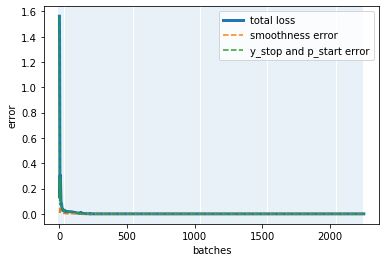

In [66]:
#plot errors after each epoch
epoch_lines = np.arange(0, epochs*batch, batch)
loss = plt.plot(losses, label = 'total loss', linewidth=3)
smoothness = plt.plot(p_smoothness_errors, label = 'smoothness error', linestyle='--')
basic = plt.plot(basic_errors, label = 'y_stop and p_start error', linestyle='--')
plt.legend()
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.show()